In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')



# Read the dataset
df = pd.read_csv('Medicaldataset.csv')
print("Original dataset shape:", df.shape)
df.head()

Original dataset shape: (1319, 9)


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


Missing values:
 Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64

Number of duplicates: 0

Data types:
 Age                           int64
Gender                        int64
Heart rate                    int64
Systolic blood pressure       int64
Diastolic blood pressure      int64
Blood sugar                 float64
CK-MB                       float64
Troponin                    float64
Result                       object
dtype: object


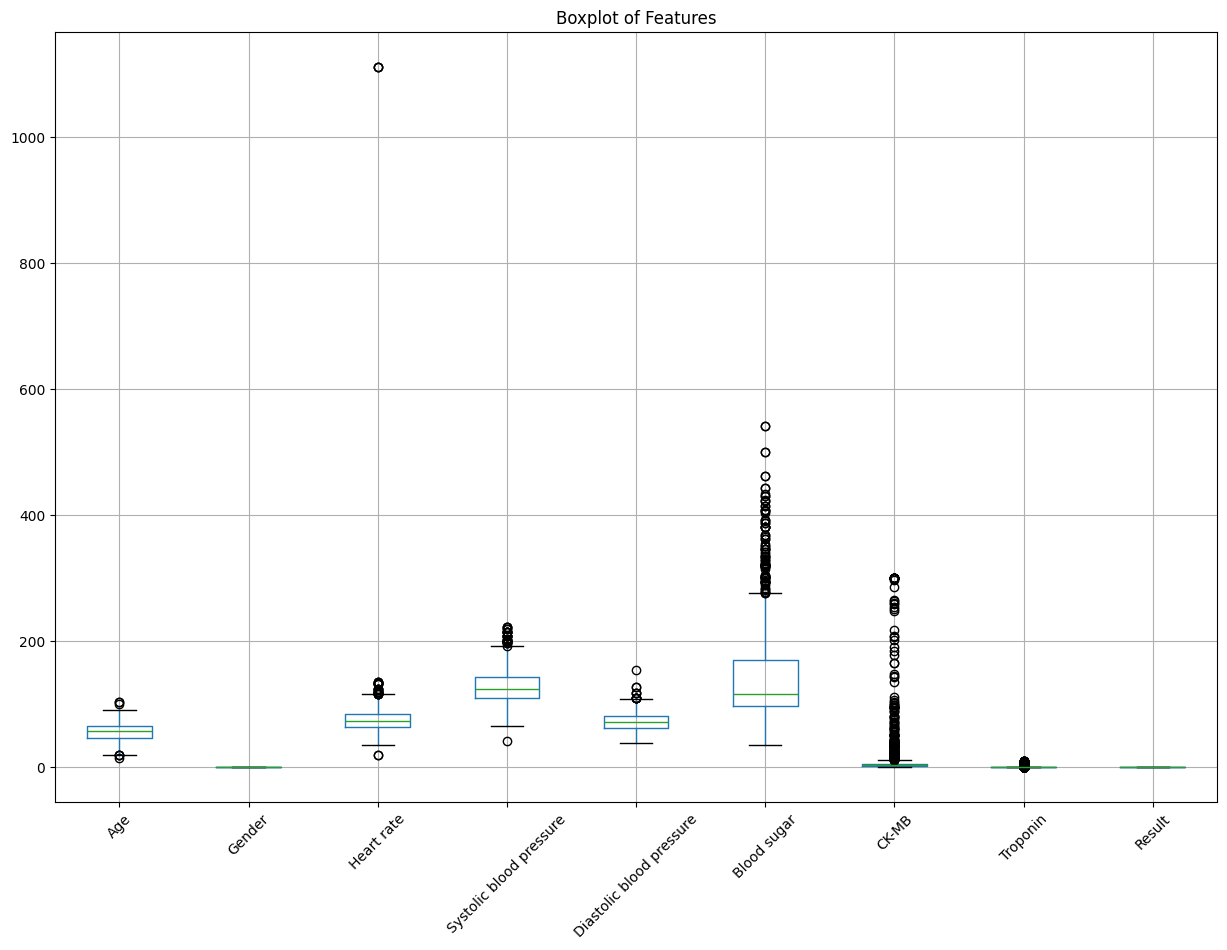


Class distribution:
 Result
1    810
0    509
Name: count, dtype: int64


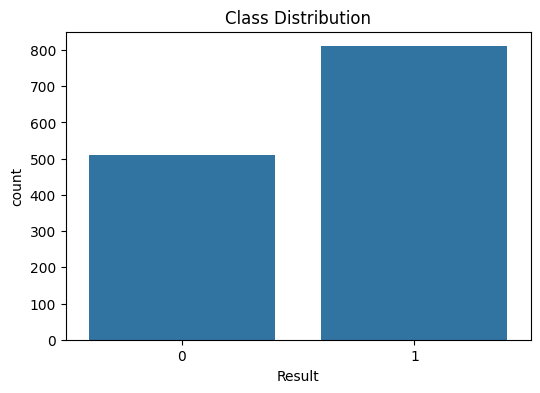

In [3]:
# Step 2: Data Preprocessing

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicates:", df.duplicated().sum())

# Check data types
print("\nData types:\n", df.dtypes)

# Convert target variable to binary (0 and 1) - do this FIRST
df['Result'] = df['Result'].map({'negative': 0, 'positive': 1})

# Check for outliers
plt.figure(figsize=(15, 10))
df.boxplot()
plt.xticks(rotation=45)
plt.title('Boxplot of Features')
plt.show()

# Handle outliers - we'll cap extreme values at 99th percentile
# Get numeric columns excluding 'Result'
numeric_cols = [col for col in df.columns if col != 'Result' and np.issubdtype(df[col].dtype, np.number)]

for col in numeric_cols:
    upper_limit = df[col].quantile(0.99)
    lower_limit = df[col].quantile(0.01)
    df[col] = np.where(df[col] > upper_limit, upper_limit,
                      np.where(df[col] < lower_limit, lower_limit, df[col]))

# Feature scaling
scaler = StandardScaler()
X = df.drop('Result', axis=1)
y = df['Result']
X_scaled = scaler.fit_transform(X)

# Display class distribution
print("\nClass distribution:\n", y.value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.show()

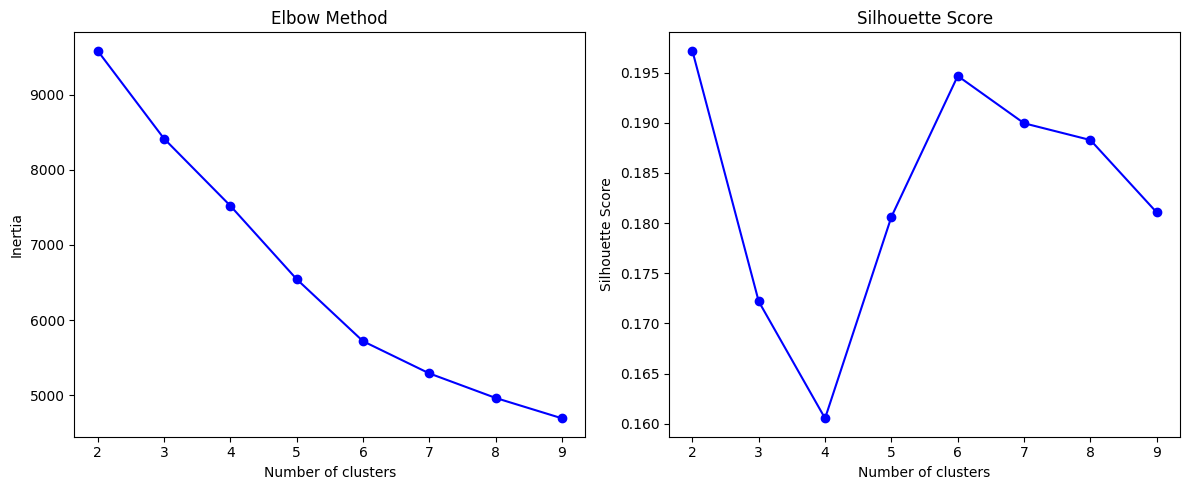


K-Means Cluster Validation:
Silhouette Score: 0.17219357971822322
Calinski-Harabasz Index: 167.2015089875963
Davies-Bouldin Index: 2.0487573720816097


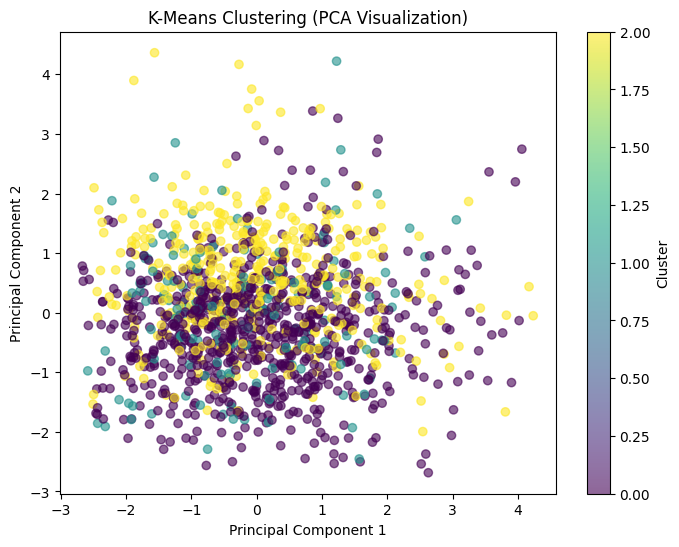

In [4]:
# Step 3: Unsupervised Learning Techniques

# Technique 1: K-Means Clustering

# Determine optimal number of clusters using Elbow method
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow curve and Silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()

# Apply K-Means with optimal k (let's say 3 based on silhouette score)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Cluster validation
print("\nK-Means Cluster Validation:")
print("Silhouette Score:", silhouette_score(X_scaled, kmeans_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, kmeans_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, kmeans_labels))

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

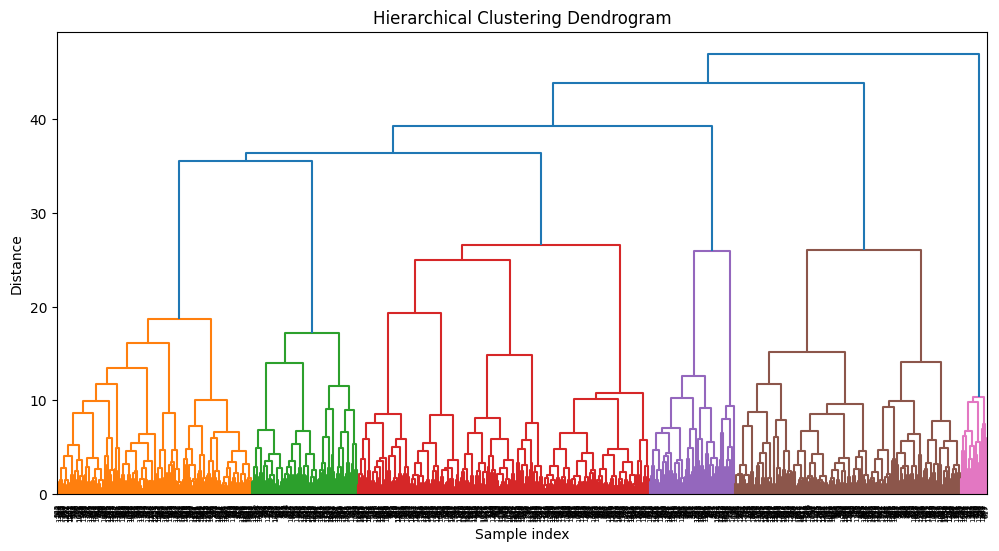


Hierarchical Clustering Validation:
Silhouette Score: 0.1348838515003473
Calinski-Harabasz Index: 160.16265085522843
Davies-Bouldin Index: 1.7912767759845725


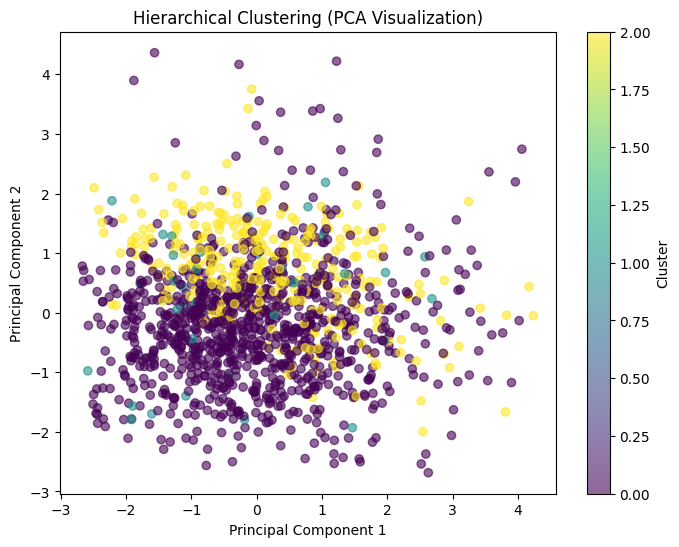

In [6]:
# Technique 2: Hierarchical Clustering

# Create linkage matrix
linked = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')  # Changed 'affinity' to 'metric'
agg_labels = agg_cluster.fit_predict(X_scaled)

# Cluster validation
print("\nHierarchical Clustering Validation:")
print("Silhouette Score:", silhouette_score(X_scaled, agg_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, agg_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, agg_labels))

# Visualize clusters using PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', alpha=0.6)
plt.title('Hierarchical Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [7]:
# Step 4: Feature Selection

# Method 1: SelectKBest with ANOVA F-value
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
selected_features_kbest = X.columns[selector.get_support()]
print("\nTop 5 features using SelectKBest:", selected_features_kbest.tolist())

# Method 2: Recursive Feature Elimination (RFE)
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_scaled, y)
selected_features_rfe = X.columns[rfe.support_]
print("Top 5 features using RFE:", selected_features_rfe.tolist())

# We'll proceed with RFE selected features
selected_features = selected_features_rfe
X_selected = X[selected_features]

# Display selected features
print("\nSelected features for modeling:", selected_features.tolist())


Top 5 features using SelectKBest: ['Age', 'Gender', 'Blood sugar', 'CK-MB', 'Troponin']
Top 5 features using RFE: ['Age', 'Gender', 'Blood sugar', 'CK-MB', 'Troponin']

Selected features for modeling: ['Age', 'Gender', 'Blood sugar', 'CK-MB', 'Troponin']


In [8]:
# Step 5: Handling Class Imbalance

# Check class distribution
print("Before balancing:")
print(y.value_counts())

# Method 1: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_selected, y)

# Method 2: SMOTE + Tomek Links (combination of over and under sampling)
smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X_selected, y)

# Display class distribution after balancing
print("\nAfter SMOTE:")
print(pd.Series(y_smote).value_counts())

print("\nAfter SMOTE + Tomek Links:")
print(pd.Series(y_smt).value_counts())

# We'll proceed with SMOTE balanced data
X_balanced, y_balanced = X_smote, y_smote

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Before balancing:
Result
1    810
0    509
Name: count, dtype: int64

After SMOTE:
Result
0    810
1    810
Name: count, dtype: int64

After SMOTE + Tomek Links:
Result
0    729
1    729
Name: count, dtype: int64

Training set shape: (1134, 5)
Test set shape: (486, 5)
